In [1]:
import itertools
import sys

import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import pandas as pd
from matplotlib import cm
from matplotlib.axes import Axes
from matplotlib.gridspec import GridSpec

sys.path.append("..")
from NGS.data import preprocess
from path import DATA_DIR, RESULT_DIR

plt.rcParams.update(
    {
        "font.family": "FreeSerif",
        "mathtext.default": "regular",
        "text.usetex": True,
        "text.latex.preamble": r"\usepackage{amsmath, amssymb}",
        "font.size": 20,
        "axes.titlesize": 20,
        "axes.labelsize": 20,
        "legend.fontsize": 20,
        "xtick.labelsize": 15,
        "ytick.labelsize": 15,
    }
)

# Graph domain interpolation/extrapololation
file_names = ["heat_train", "heat_test_int", "heat_test_ext"]

In [2]:
def get_mae(
    pred_trajectories: list[npt.NDArray[np.float32]],
    true_trajectories: list[npt.NDArray[np.float32]],
) -> list[float]:
    return [
        np.abs(pred - true).mean().item()
        for pred, true in zip(pred_trajectories, true_trajectories)
    ]

def get_maes(missing: float, noise: float) -> dict[str, list[float]]:
    exp_id = f"heat_p{missing}_s{noise}"
    result_dir = RESULT_DIR / exp_id
    maes: dict[str, list[float]] = {}

    for file_name in file_names:
        # Load data
        data_df = pd.read_pickle(DATA_DIR / f"{file_name}.pkl")
        pred_df = pd.read_pickle(result_dir / f"{file_name}.pkl")
        num_samples = len(pred_df)

        if "train" in file_name:
            train, val = preprocess(data_df, val_ratio=0.2)
            train_true_trajectories = train["trajectories"]
            train_pred_trajectories = pred_df["trajectories"][: -int(0.2 * num_samples)]
            maes["train"] = get_mae(  # MAE except initial condition
                [traj[1:] for traj in train_pred_trajectories],
                [traj[1:] for traj in train_true_trajectories],
            )

            val_true_trajectories = val["trajectories"]
            val_pred_trajectories = pred_df["trajectories"][-int(0.2 * num_samples) :]
            maes["val"] = get_mae(  # MAE except initial condition
                [traj[1:] for traj in val_pred_trajectories],
                [traj[1:] for traj in val_true_trajectories],
            )
        else:
            _, test = preprocess(data_df)
            true_trajectories = test["trajectories"]
            pred_trajectories = pred_df["trajectories"]

            # Time domain interpolation/extrapolation
            key = "_".join(e for e in file_name.split("_")[1:])
            maes[key + "_int"] = get_mae(  # MAE except initial condition
                [traj[1:21] for traj in pred_trajectories],
                [traj[1:21] for traj in true_trajectories],
            )
            maes[key + "_ext"] = get_mae(
                [traj[21:] for traj in pred_trajectories],
                [traj[21:] for traj in true_trajectories],
            )
    return maes


In [3]:
missings = [0.0, 0.05, 0.1, 0.2]
noises = [0.0, 0.0001, 0.001, 0.01]

graph_int_time_int: list[np.ndarray] = []
graph_int_time_ext: list[np.ndarray] = []
graph_ext_time_int: list[np.ndarray] = []
graph_ext_time_ext: list[np.ndarray] = []
for missing, noise in itertools.product(missings, noises):
    tmp_maes = get_maes(missing, noise)
    graph_int_time_int.append(np.array(tmp_maes["test_int_int"]))
    graph_ext_time_int.append(np.array(tmp_maes["test_ext_int"]))
    graph_int_time_ext.append(np.array(tmp_maes["test_int_ext"]))
    graph_ext_time_ext.append(np.array(tmp_maes["test_ext_ext"]))

heat_maes: dict[str, np.ndarray] = {}
heat_maes["graph_int_time_int"] = np.stack(graph_int_time_int).reshape(4, 4, -1)
heat_maes["graph_ext_time_int"] = np.stack(graph_ext_time_int).reshape(4, 4, -1)
heat_maes["graph_int_time_ext"] = np.stack(graph_int_time_ext).reshape(4, 4, -1)
heat_maes["graph_ext_time_ext"] = np.stack(graph_ext_time_ext).reshape(4, 4, -1)


In [4]:
def plot_heatmap(ax: Axes, domain: str) -> cm.ScalarMappable:
    maes = heat_maes[domain] * 1e4
    avg = maes.mean(axis=-1)
    ci = 1.96 * maes.std(axis=-1) / np.sqrt(maes.shape[-1])

    im = ax.imshow(
        avg, cmap="pink_r", norm="log", interpolation="none", vmin=1.0, vmax=100.0
    )

    for missing_idx, noise_idx in itertools.product(
        range(len(missings)), range(len(noises))
    ):
        color = "w" if noise_idx == 3 else "k"
        text = (
            f"{avg[missing_idx, noise_idx]:.2f}\n"
            + r"$\pm$"
            + f"{ci[missing_idx, noise_idx]:.2f}"
        )

        ax.text(
            noise_idx,
            missing_idx,
            text,
            ha="center",
            va="center",
            color=color,
            fontsize=15,
        )

    ax.set_xticks([])
    ax.set_yticks([])
    ax.tick_params(axis="both", length=0)
    ax.add_patch(
        patches.Rectangle(
            xy=(1.5, 1.5),
            width=1.0,
            height=1.0,
            linewidth=2,
            edgecolor="k",
            facecolor="none",
        )
    )
    return im


def shrink_cbar(cax, shrink: float):
    b = cax.get_position()
    pad = 0.5 * (1.0 - shrink) * b.height
    b.y0 += pad
    b.y1 -= pad
    cax.set_position(b)

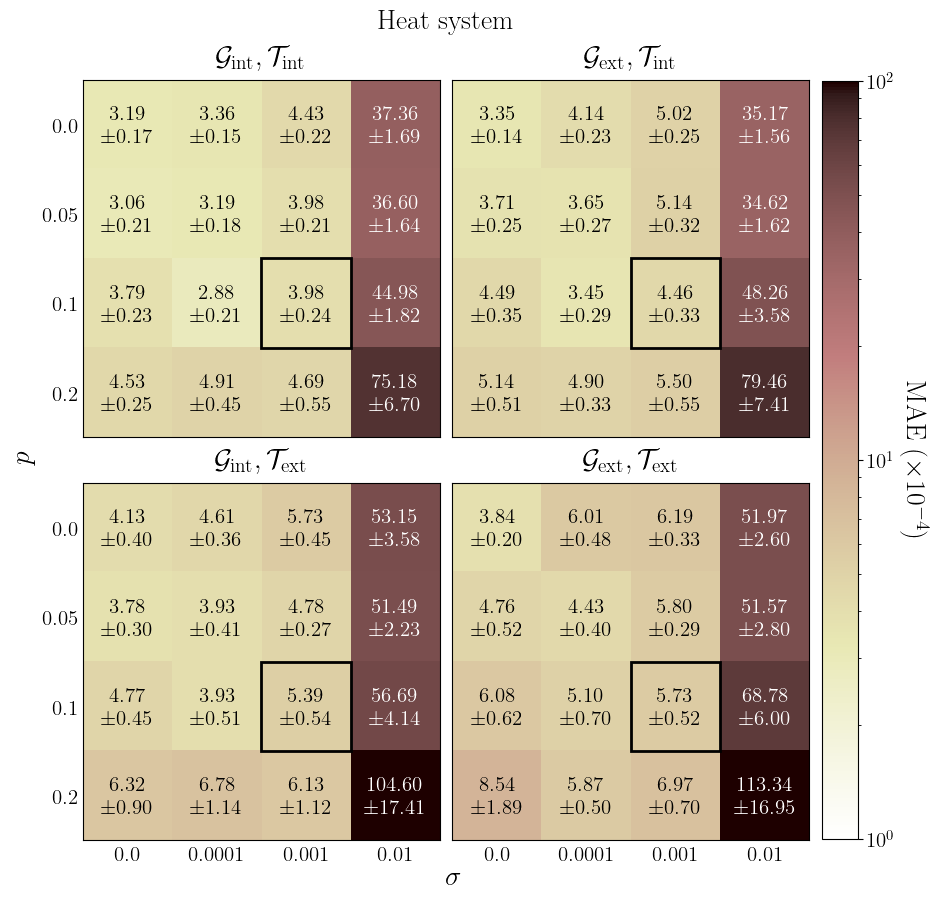

In [5]:
fig = plt.figure(figsize=(10, 10))

gs = GridSpec(2, 3, width_ratios=[1, 1, 0.1], wspace=0.05, hspace=0.1)
gs.tight_layout(fig)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])
cax = fig.add_subplot(gs[:, 2])

# Heatmaps
for ax, domain in zip([ax1, ax2, ax3, ax4], heat_maes.keys()):
    im = plot_heatmap(ax, domain)

# Colorbar
fig.colorbar(im, cax=cax, location="right")
shrink_cbar(cax, shrink=0.985)

# Labels
cax.set_ylabel("MAE " + r"$(\times 10^{-4})$", rotation=-90, labelpad=25)

# Ticks
ax1.set_yticks(np.arange(4), labels=map(str, missings))
ax3.set_xticks(np.arange(4), labels=map(str, noises))
ax3.set_yticks(np.arange(4), labels=map(str, missings))
ax4.set_xticks(np.arange(4), labels=map(str, noises))

# Titles
ax1.set_title(r"$\mathcal{G}_\text{int}, \mathcal{T}_\text{int}$", y=1.02)
ax2.set_title(r"$\mathcal{G}_\text{ext}, \mathcal{T}_\text{int}$", y=1.02)
ax3.set_title(r"$\mathcal{G}_\text{int}, \mathcal{T}_\text{ext}$", y=1.02)
ax4.set_title(r"$\mathcal{G}_\text{ext}, \mathcal{T}_\text{ext}$", y=1.02)
ax_ghost = fig.add_subplot(gs[:, :2])
ax_ghost.set_axis_off()
ax_ghost.set_title("Heat system", y=1.05)
ax_ghost.text(-0.1, 0.5, "$p$", rotation=90, transform=ax_ghost.transAxes)
ax_ghost.text(0.5, -0.05, r"$\sigma$", transform=ax_ghost.transAxes)

# fig.savefig("figS1.pdf", bbox_inches="tight")
fig.show()